# Data wrangling and modelling for the product ingredients

_________________________________________________________________________________

**Reference file:**
- combined_data.json

__________________________________________________________________________________

## 0.0 Importing libraries

In [1]:
#Import necessary libraries
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
#!pip install textsearch
#!pip install contractions
from nltk.tokenize import sent_tokenize
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation

In [3]:
#! pip install fuzzywuzzy
#! pip install python-Levenshtein
import fuzzywuzzy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from itertools import chain

In [122]:
#Import necessary libraries
#!pip install textsearch
#!pip install contractions
from nltk.tokenize import sent_tokenize
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score

In [106]:
import warnings
warnings.filterwarnings("ignore")

# 1.0 Loading files

In [4]:
with open('../data/processed_data/combined_data.json', 'r') as file:
    data= json.load(file)
df=pd.DataFrame.from_dict(data)

In [5]:
df.head().T

,0,1,2,3,4
brand,Glow Recipe,Tatcha,goop,CLINIQUE,Tata Harper
product_name,Glow Recipe Watermelon Glow PHA +BHA Pore-Tigh...,Tatcha Pure One Step Camellia Oil Cleanser,goop GOOPGLOW Microderm Instant Glow Exfoliator,CLINIQUE Take The Day Off Makeup Remover For L...,Tata Harper Regenerating Exfoliating Cleanser
product_type,toners,face wash and cleansers,exfoliators and peels,face wash and cleansers,face wash and cleansers
num_likes,125100,107600,12900,76700,31000
rating,4.5,4.5,4.5,4.5,4.5
num_reviews,1900,1700,1200,3100,567
sensitive_type,0,1,0,0,0
combination_type,1,1,1,0,1
oily_type,1,1,1,0,0
normal_type,1,1,1,0,0


_________________________

## 2.0 Data wrangling and pre-processing

### *Approach 1: Using Fuzzymatch*

In [6]:
df_new=df.copy()

### 2.1 Clean data

In [7]:
def clean_ingr(text):
    '''
    text pre-processing for ingredients list
    '''
    text = str(text)
    text= unicodedata.normalize("NFKD", text)
    text= re.sub(r'[/\()-]',' ', text)
    text= re.sub(r'[^a-zA-Z\s,]', '', text)
    text= re.sub(r'\s*([,])\s*', ', ',text)
    text= text.lower().replace('\n','').replace('  ', ' ')
    
    new_text= re.split(', ', str(text))
    
    new_text= [i.strip() for i in new_text if i!='']
    
    #return list
    return new_text

In [8]:
df_new['ingr_list']=df_new['ingr_list'].apply(lambda x: clean_ingr(x))

In [9]:
df_new['ingr_list']

0       [opuntia ficus indica cactus extract, citrullu...
1       [cetyl ethylhexanoate, oryza sativa rice bran ...
2       [aqua, alumina, glycerin, cetearyl alcohol, gl...
3       [water, isohexadecane, dimethicone, cyclopenta...
4       [hordeum vulgare leaf juice, cetearyl alcohol,...
                              ...                        
1333    [rosa canina rosehip fruit oil, helianthus ann...
1334    [water aqua eau, butylene glycol, dimethicone,...
1335    [water, butylene glycol, glycerin, caprylic ca...
1336    [badaptive superfoodstm microcapsule complex, ...
1337    [aqua water, butylene glycol, glycerin, propan...
Name: ingr_list, Length: 1338, dtype: object

### 2.2 Simplify ingredients list using Fuzzywuzzy

In [10]:
#Create complete list of unique ingredients
ingr = list(df_new['ingr_list'])
ingr_list = list(set(chain(*ingr)))

In [11]:
print(f'{len(ingr_list)} unique ingredients before fuzzy match')

5963 unique ingredients before fuzzy match


**1. Calculating similarities**

Used fuzzy token sort ratio but other metrics can also be used (i.e. Levin)

In [12]:
ingr_df = pd.DataFrame(ingr_list)
ingr_df.columns = ['ingredients']


In [13]:
fuzz.token_sort_ratio('aha glycolic acid', 'aha acid')

64

In [14]:
ct= pd.crosstab(ingr_df['ingredients'], ingr_df['ingredients'])
ct= ct.apply(lambda col: [fuzz.token_sort_ratio(col.name, x) for x in col.index])

In [15]:
#Fuzz ratio taking so long! 
ct.head()

ingredients,a,a blend of essential amino acids and calcium,abies pectinata leaf oil,abies sibirica oil,acacia dealbata flower stem extract,acacia decurrens flower wax,acacia decurrens jojoba sunflower seed wax polyglyceryl esters,acacia farnesiana flower wax,acacia honey,acacia senegal gum,...,zingiber officinale ginger root extract,zingiber officinale ginger root oil,zingiber officinale ginger water,zingiber officinale root extract,zingiber officinale root oil,zingiber officinale root oil ginger root oil,zingiber zerumbet extract,ziziphus jujuba fruit extract,zizyphus jujuba fruit extract,zizyphus jujuba seed extract
ingredients,,,,,,,,,,,,,,,,,,,,,
a,100,4,8,11,6,7,3,7,15,11,...,5,6,6,6,7,4,8,7,7,7
a blend of essential amino acids and calcium,4,100,38,32,41,39,36,39,29,45,...,34,30,32,32,31,32,29,27,27,31
abies pectinata leaf oil,8,38,100,57,37,35,33,35,33,38,...,35,44,36,36,42,38,29,26,26,27
abies sibirica oil,11,32,57,100,26,36,28,35,27,33,...,39,38,40,36,43,35,37,30,26,26
acacia dealbata flower stem extract,6,41,37,26,100,58,47,57,38,42,...,38,31,33,42,35,30,40,38,38,35


**2. Replace 100s since this is a comparison to itself**

In [16]:
ct[ct==100]=0

**3. Create a dictionary to be used later for replacing values**

In [17]:
def create_mapping(df, threshold=83):
    '''
    returns dictionary mapping the ingredient names to be replaced and the new term to be used 
    '''
    replaced=[]
    mapping={}
    for i in df[::-1]: #reverse to get the ingredient version 
        #returns col 
        col =df[i]
        cur_ingr = col.name
        close_strings= list(col[col>threshold].index)

        #check if ingr has already been replaced, if so, then check dictionary for ultimate word 
        #print(cur_ingr, )
        #print(close_strings)
        if cur_ingr in replaced:
            #print('Ingredient already replaced')
            for value in close_strings:
                mapping[value] = mapping[cur_ingr]
                replaced.append(value)
        else:
            #print('Replacing ', close_strings, ' with ', cur_ingr)
            for value in close_strings:
                mapping[value]=cur_ingr
                replaced.append(value)
        #print('\n')       
    #print('Full list of values replaced: \n', replaced)
    #print(f'{len(mapping)} ingredients to be mapped')
    return mapping

In [74]:
mapping = create_mapping(ct, 75)

In [91]:
mapped_df= pd.DataFrame.from_dict(mapping, orient='index')

In [92]:
mapped_df.reset_index(inplace=True)
mapped_df.rename(columns={'index': 'old', 0:'new'}, inplace=True)

In [96]:
mapped_df.loc[mapped_df['old'].str.contains('fragra'),'new']='fragrance'

**4. Replaced values in the ingredients list**

In [100]:
def replace_ingr(alist, dict_map):
    '''
    Takes in a list and replaces each value in the list according to the dictionary
    Returns comma separated doc/string
    '''
    for i in range(len(alist)):
        if alist[i] in dict_map.keys():
            alist[i] = dict_map[alist[i]]
    
    new_text = ", ".join(alist)
    return new_text

In [101]:
df_new['ingr_list']= df_new['ingr_list'].apply(lambda x: replace_ingr(x, mapping))
df_new['ingr_list']

0       opuntia ficus indica cactus extract, citrullus...
1       c alkyl ethylhexanoate, oryza sativa bran oil ...
2       aqua, alumina, and glycerin, alcohol denat, gl...
3       other water, hexadecene, dimethicone silylate,...
4       hordeum vulgare leaf juice, alcohol denat, eth...
                              ...                        
1333    rosa canina rosehip seed extract, helianthus a...
1334    aqua  water, butylene glycol, dimethicone sily...
1335    other water, butylene glycol, and glycerin, ca...
1336    badaptive superfoodstm microcapsule complex, a...
1337    aqua  water, butylene glycol, and glycerin, pr...
Name: ingr_list, Length: 1338, dtype: object

In [102]:
ingr2 = list(df_new['ingr_list'].apply(lambda x: x.split(',')))
ingr_list2 = list(set(chain(*ingr2)))

In [103]:
print(f'{len(ingr_list2)} unique ingredients after fuzzy match')

2998 unique ingredients after fuzzy match


## 3.0 Modelling

In [104]:
#Defined custom tokenizer
def separate_ingr(text):
    '''
    Custom tokenizer: Returns a list of ingredients by partitioning text based on commas 
    '''
    new_text= re.split(', ', str(text))
    new_text= [i.strip() for i in new_text if i!=''] 
    #recreate the document from filtered tokens
    return new_text

In [105]:
ingr_list = list(df_new.ingr_list)

**1. Count Vectorizer**

In [107]:
cv= CountVectorizer(ingr_list, tokenizer= separate_ingr)
sparse_matrix= cv.fit_transform(ingr_list)
#print(cv.get_feature_names())

In [108]:
listed_ingr=cv.get_feature_names
listed_ingr

<bound method CountVectorizer.get_feature_names of CountVectorizer(input=['opuntia ficus indica cactus extract, citrullus lanatus '
                       'watermelon fruit, and glycerin, azelaic acid, '
                       'gluconolactone, sodium caproyl lauroyl lactylate, '
                       'benzyl salicylate, salix alba bark extract salix alba '
                       'willow bark extract, melaleuca alternafolia tea tree '
                       'leaf oil, ferment extract, lactobacillus lemon peel '
                       'ferment extract, cucumis sativus cucumber concomb...
                       'niacinamide, zinc chloride',
                       'aqua  water, polypropylene, polaxmer, pheno xyethano, '
                       'polyglyceryl beeswax, dipotassium edta, sodium caproyl '
                       'lauroyl lactylate, disodium succinate, butylene '
                       'glycol, butylparaben, fragrance  parf um, '
                       'biosaccharide gum, capryl 

In [109]:
ingr_term_matrix = sparse_matrix.todense()
ingr_df = pd.DataFrame(ingr_term_matrix, columns= cv.get_feature_names())

In [110]:
ingr_df.shape

(1338, 2890)

**2. Compute pairwise similarity using cosine**

In [120]:
sim_df = pd.DataFrame(cosine_similarity(ingr_term_matrix))
sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337
0,1.000000,0.048113,0.073922,0.000000,0.246533,0.185185,0.150278,0.251976,0.126554,0.000000,...,0.099015,0.194444,0.048493,0.080064,0.261891,0.000000,0.184334,0.123267,0.176604,0.216506
1,0.048113,1.000000,0.032009,0.138675,0.080064,0.048113,0.117130,0.000000,0.123299,0.123299,...,0.171499,0.144338,0.125988,0.173344,0.204124,0.000000,0.095783,0.120096,0.057354,0.062500
2,0.073922,0.032009,1.000000,0.035511,0.205023,0.073922,0.279944,0.139700,0.252590,0.105246,...,0.197623,0.221766,0.161311,0.266333,0.121965,0.078406,0.183956,0.143516,0.146868,0.256074
3,0.000000,0.138675,0.035511,1.000000,0.044412,0.106752,0.129944,0.000000,0.091192,0.136788,...,0.142695,0.160128,0.174714,0.076923,0.188713,0.000000,0.185957,0.133235,0.095443,0.034669
4,0.246533,0.080064,0.205023,0.044412,1.000000,0.030817,0.250078,0.139771,0.157949,0.078975,...,0.082385,0.231125,0.221917,0.177646,0.239697,0.065372,0.199387,0.076923,0.091840,0.220176


In [121]:
#Similarity of product to one another
sim_df.shape

(1338, 1338)

In [176]:
#Add product names 
sim_df.index = np.array(df_new['product_name'])
sim_df.columns= np.array(df_new['product_name'])

**3. Compute pairwise similarity using jaccard similarity**

*Adding product name for easy reference*

In [125]:
df_new.reset_index(drop=True, inplace=True)

In [126]:
#New df complete with product name and ingredients 
product_ingr_matrix = df_new[['product_name']].join(ingr_df.copy())

In [127]:
#Change index to match the original 
product_ingr_matrix.index =df.index
prod_ingr_matrix1= product_ingr_matrix.set_index('product_name')

In [130]:
#Create list of products
products = prod_ingr_matrix1.index.to_list()

In [131]:
#Matrix for product similarity
prodxprod = pd.DataFrame(columns=products, index=products)

In [132]:
def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

In [145]:
for p1 in products:
    for p2 in products:
        prodxprod.loc[p1,p2] = jaccard_binary(np.array(prod_ingr_matrix1.loc[p1]), 
                                             np.array(prod_ingr_matrix1.loc[p2]))

In [149]:
prodxprod.head(15)

,Glow Recipe Watermelon Glow PHA +BHA Pore-Tight Toner,Tatcha Pure One Step Camellia Oil Cleanser,goop GOOPGLOW Microderm Instant Glow Exfoliator,"CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips",Tata Harper Regenerating Exfoliating Cleanser,Glow Recipe Blueberry Bounce Gentle Cleanser,Caudalie Vinopure Pore Purifying Gel Cleanser,REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner,The INKEY List Salicylic Acid Acne + Pore Cleanser,Proactiv Deep Cleansing Face Wash,...,fresh Crème Ancienne® Eye Cream,The INKEY List Brighten-i Eye Cream,belif Peat Miracle Revital Eye Cream,innisfree Green Tea Seed Intensive Hydrating Eye Cream,First Aid Beauty Eye Duty Triple Remedy A.M. Gel Cream,KORA Organics Noni Radiant Eye Oil,Peter Thomas Roth Water Drench® Hyaluronic Cloud Hydrating Eye Gel,Dr. Dennis Gross Skincare Hyaluronic Marine Dew It Right Eye Gel,Dr. Dennis Gross Skincare Stress SOS Eye Cream™ with Niacinamide,Guerlain Abeille Royale Anti-Aging Eye Cream
Glow Recipe Watermelon Glow PHA +BHA Pore-Tight Toner,1.0,0.027778,0.031746,0.0,0.096154,0.097561,0.040816,0.135135,0.06383,0.0,...,0.057692,0.052632,0.028169,0.056604,0.105263,0.0,0.068493,0.071429,0.08642,0.092308
Tatcha Pure One Step Camellia Oil Cleanser,0.027778,1.0,0.018868,0.083333,0.045455,0.030303,0.052632,0.0,0.083333,0.103448,...,0.073171,0.088889,0.050847,0.097561,0.106383,0.0,0.063492,0.065217,0.026667,0.034483
goop GOOPGLOW Microderm Instant Glow Exfoliator,0.031746,0.018868,1.0,0.018868,0.104478,0.016393,0.133333,0.072727,0.098361,0.034483,...,0.107692,0.1,0.071429,0.123077,0.066667,0.033333,0.079545,0.069444,0.060606,0.128205
"CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips",0.0,0.083333,0.018868,1.0,0.022222,0.0625,0.052632,0.0,0.054054,0.103448,...,0.047619,0.088889,0.068966,0.046512,0.106383,0.0,0.098361,0.065217,0.026667,0.016949
Tata Harper Regenerating Exfoliating Cleanser,0.096154,0.045455,0.104478,0.022222,1.0,0.018868,0.090909,0.0625,0.072727,0.04,...,0.04918,0.078125,0.093333,0.048387,0.090909,0.038462,0.060976,0.045455,0.043011,0.081081
Glow Recipe Blueberry Bounce Gentle Cleanser,0.097561,0.030303,0.016393,0.0625,0.018868,1.0,0.043478,0.026316,0.044444,0.081081,...,0.019608,0.036364,0.076923,0.0,0.071429,0.0,0.027397,0.096154,0.024096,0.030303
Caudalie Vinopure Pore Purifying Gel Cleanser,0.040816,0.052632,0.133333,0.052632,0.090909,0.043478,1.0,0.0,0.152174,0.022222,...,0.115385,0.067797,0.070423,0.072727,0.081967,0.0,0.08,0.067797,0.045977,0.138462
REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner,0.135135,0.0,0.072727,0.0,0.0625,0.026316,0.0,1.0,0.023256,0.0,...,0.065217,0.018868,0.015152,0.06383,0.036364,0.0,0.043478,0.038462,0.037975,0.065574
The INKEY List Salicylic Acid Acne + Pore Cleanser,0.06383,0.083333,0.098361,0.054054,0.072727,0.044444,0.152174,0.023256,1.0,0.125,...,0.096154,0.127273,0.056338,0.183673,0.140351,0.044444,0.126761,0.127273,0.111111,0.15873
Proactiv Deep Cleansing Face Wash,0.0,0.103448,0.034483,0.103448,0.04,0.081081,0.022222,0.0,0.125,1.0,...,0.041667,0.078431,0.0625,0.085106,0.137255,0.0,0.073529,0.122449,0.024691,0.064516


In [150]:
prod1= np.array(prod_ingr_matrix1.loc['Paula\'s Choice CLEAR Pore Normalizing Acne Cleanser'])
prod2= np.array(prod_ingr_matrix1.loc['Peter Thomas Roth 3% Glycolic Solutions Cleanser'])
jaccard_binary(prod1, prod2)

0.1724137931034483

**Number of similar ingredients**

In [159]:
#Number of similar ingredients
dot_prod = prod_ingr_matrix1.dot(prod_ingr_matrix1.T) 

In [161]:
dot_prod

product_name,Glow Recipe Watermelon Glow PHA +BHA Pore-Tight Toner,Tatcha Pure One Step Camellia Oil Cleanser,goop GOOPGLOW Microderm Instant Glow Exfoliator,"CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips",Tata Harper Regenerating Exfoliating Cleanser,Glow Recipe Blueberry Bounce Gentle Cleanser,Caudalie Vinopure Pore Purifying Gel Cleanser,REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner,The INKEY List Salicylic Acid Acne + Pore Cleanser,Proactiv Deep Cleansing Face Wash,...,fresh Crème Ancienne® Eye Cream,The INKEY List Brighten-i Eye Cream,belif Peat Miracle Revital Eye Cream,innisfree Green Tea Seed Intensive Hydrating Eye Cream,First Aid Beauty Eye Duty Triple Remedy A.M. Gel Cream,KORA Organics Noni Radiant Eye Oil,Peter Thomas Roth Water Drench® Hyaluronic Cloud Hydrating Eye Gel,Dr. Dennis Gross Skincare Hyaluronic Marine Dew It Right Eye Gel,Dr. Dennis Gross Skincare Stress SOS Eye Cream™ with Niacinamide,Guerlain Abeille Royale Anti-Aging Eye Cream
product_name,,,,,,,,,,,,,,,,,,,,,
Glow Recipe Watermelon Glow PHA +BHA Pore-Tight Toner,27,1,3,0,8,5,5,6,4,0,...,3,7,2,3,10,0,10,4,8,9
Tatcha Pure One Step Camellia Oil Cleanser,1,16,1,2,2,1,3,0,3,3,...,4,4,4,5,6,0,4,3,2,2
goop GOOPGLOW Microderm Instant Glow Exfoliator,3,1,61,1,10,3,14,5,12,5,...,9,12,10,15,7,3,15,7,10,16
"CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips",0,2,1,13,1,2,3,0,2,3,...,3,4,5,2,5,0,7,3,3,1
Tata Harper Regenerating Exfoliating Cleanser,8,2,10,1,39,1,10,4,6,3,...,3,10,11,8,11,2,13,3,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KORA Organics Noni Radiant Eye Oil,0,0,3,0,2,0,0,0,2,0,...,5,1,4,2,2,24,1,1,6,6
Peter Thomas Roth Water Drench® Hyaluronic Cloud Hydrating Eye Gel,10,4,15,7,13,2,11,5,14,13,...,9,24,18,22,30,1,109,16,33,29
Dr. Dennis Gross Skincare Hyaluronic Marine Dew It Right Eye Gel,4,3,7,3,3,6,7,2,9,10,...,4,13,11,10,11,1,16,39,13,17


## 4. Exploring the results 

#### What are the most similar products to X in terms of similarity?

In [309]:
x= products[25]
x

'Estée Lauder Gentle Eye Makeup Remover'

In [341]:
df_new.columns

Index(['brand', 'product_name', 'product_type', 'num_likes', 'rating',
       'num_reviews', 'sensitive_type', 'combination_type', 'oily_type',
       'normal_type', 'dry_type', 'clean_sephora', 'cruelty_free', 'vegan',
       'best_for_skintype', 'award', 'pricepervol', 'highlighted_ingr',
       'clinical_results', 'formulation_type', 'richness', 'Acne/Blemishes',
       'Anti-Aging', 'Dark Circles', 'Dark spots', 'Dryness',
       'Dullness/Uneven Texture', 'Hair Dryness', 'Hydrating',
       'Loss of firmness', 'Pores ', 'Redness', 'num_excl_ingr',
       'AHA/Glycolic Acid', 'Hyaluronic Acid', 'Salicylic Acid', 'Vitamin C',
       'ingr_list'],
      dtype='object')

In [517]:
sim_df["Murad Acne Control Clarifying Cleanser"].sort_values(axis=0)

Prima Night Magic 300mg CBD Intensive Face Oil                   0.000000
Drunk Elephant Lala Retro™ Whipped Moisturizer with Ceramides    0.000000
Edible Beauty Snowflower Illuminating Face Oil                   0.000000
Moon Juice Holy Yoni Adaptogenic Oil                             0.000000
Josie Maran 100 percent Pure Argan Oil Light                     0.000000
                                                                   ...   
Murad Acne Body Wash                                             0.375470
Murad Outsmart Acne Clarifying Treatment                         0.378808
Murad Acne Control Clarifying Cream Cleanser                     0.432789
Murad Intensive-C® Radiance Peel                                 0.449921
Murad Acne Control Clarifying Cleanser                           1.000000
Name: Murad Acne Control Clarifying Cleanser, Length: 1338, dtype: float64

In [518]:
def similar_prod(item, n=10, all_types = True):
    '''
    return the n most similar products
    '''
    reco = sim_df[[item]].sort_values(ascending=False)
    tp =pd.DataFrame(reco)[0:n+1]
    tp.rename(columns={item:'cos_score'}, inplace=True)
    tp['cos_score']= np.round(tp['cos_score']*100,2)
    for i in list(tp.index):
        tp.loc[i, 'jac_score'] = np.round(jaccard_binary(np.array(prod_ingr_matrix1.loc[item]), np.array(prod_ingr_matrix1.loc[i]))*100,2)
        tp.loc[i, 'num_ingr'] = str(dot_prod[item][i])+'/'+ str(dot_prod[item][item])
        tp.loc[i, 'pricepervol'] = np.round(df_new[df_new['product_name']==i]['pricepervol'].values[0],2)
        tp.loc[i, 'product_type'] = df_new[df_new['product_name']==i]['product_type'].values[0]
        
    if all_types==True:
        return tp 
    else:
        ptype = tp.loc[item, 'product_type']
        return tp.loc[tp['product_type']==ptype]


In [530]:
sim_df.loc[:,item]].sort_values(by=item, ascending=False)

,La Mer The Eye Concentrate Cream
La Mer The Eye Concentrate Cream,1.000000
La Mer The Eye Balm Intense,0.603327
Estée Lauder Revitalizing Supreme Global Anti-Aging Eye Balm,0.538382
La Mer The Concentrate,0.531107
La Mer The Lifting Eye Serum,0.520483
...,...
Evian Brumisateur® Natural Mineral Water Facial Spray Travel Duo,0.000000
fresh Lotus Youth Preserve Eye Cream,0.000000
Herbivore Jasmine Green Tea Oil Control Toner,0.000000
FARSÁLI Volcanic Elixir Polynesian Beauty Oil,0.000000


In [531]:
type(sim_df["Murad Acne Control Clarifying Cleanser"])

pandas.core.series.Series

In [358]:
def similar_prod(item, n=10, all_types = True):
    tp =pd.DataFrame(sim_df[item].sort_values(ascending=False))[0:n+1]
    tp.rename(columns={item:'cos_score'}, inplace=True)
    tp['cos_score']= np.round(tp['cos_score']*100,2)
    for i in list(tp.index):
        tp.loc[i, 'jac_score'] = np.round(jaccard_binary(np.array(prod_ingr_matrix1.loc[item]), np.array(prod_ingr_matrix1.loc[i]))*100,2)
        tp.loc[i, 'num_ingr'] = str(dot_prod[item][i])+'/'+ str(dot_prod[item][item])
        tp.loc[i, 'pricepervol'] = np.round(df_new[df_new['product_name']==i]['pricepervol'].values[0],2)
        tp.loc[i, 'product_type'] = df_new[df_new['product_name']==i]['product_type'].values[0]
        
    if all_types==True:
        return tp 
    else:
        ptype = tp.loc[item, 'product_type']
        return tp.loc[tp['product_type']==ptype]
        

In [362]:
similar_prod("Murad Acne Control Clarifying Cleanser",15, True)

,cos_score,jac_score,num_ingr,pricepervol,product_type
Murad Acne Control Clarifying Cleanser,100.00,100.00,38/38,4.74,face wash and cleansers
Murad Intensive-C® Radiance Peel,44.99,28.57,20/38,34.71,exfoliators and peels
Murad Acne Control Clarifying Cream Cleanser,43.28,29.85,22/38,5.33,face wash and cleansers
Murad Outsmart Acne Clarifying Treatment,37.88,25.00,17/38,25.88,"essences, serums and treatments"
Murad Acne Body Wash,37.55,23.08,15/38,5.18,face wash and cleansers
Murad Renewing Cleansing Cream,36.84,22.58,14/38,5.93,face wash and cleansers
Murad Rapid Relief Acne Spot Treatment,34.96,20.00,12/38,46.00,"essences, serums and treatments"
Murad Essential-C Eye Cream SPF 15 PA++,33.49,20.00,14/38,140.00,eye creams and treatments
Murad Clarifying Water Gel,32.19,17.28,16/38,25.88,moisturizers and creams
Murad Retinol Youth Renewal Eye Serum,32.16,19.12,13/38,170.00,eye creams and treatments


#### How similar is Product A to Product B?

In [382]:
def compare_ingr(i, item):
    '''
    Returns similarity between two products
    '''
    print(f'Similarity of {i} to {item}')
    tp =pd.DataFrame()
    tp.loc[i, 'cos_score']= np.round(sim_df[item][i]*100,2)
    tp.loc[i, 'jac_score'] = np.round(jaccard_binary(np.array(prod_ingr_matrix1.loc[item]), np.array(prod_ingr_matrix1.loc[i]))*100,2)
    #tp.loc[i, 'num_ingr'] = str(dot_prod[item][i])+'/'+ str(dot_prod[item][item])
    #tp.loc[i, 'pricepervol'] = np.round(df_new[df_new['product_name']==i]['pricepervol'].values[0],2)
    #tp.loc[i, 'product_type'] = df_new[df_new['product_name']==i]['product_type'].values[0]
    return tp

In [383]:
compare_ingr('SK-II SKINPOWER Essence Serum', 'SK-II Ultimate Revival Eye Cream')

Similarity of SK-II SKINPOWER Essence Serum to SK-II Ultimate Revival Eye Cream


,cos_score,jac_score
SK-II SKINPOWER Essence Serum,58.04,39.29


### Analysis of product similarity according to ingredients

In [412]:
matrix = sim_df.copy()
#force self comparisons into NaN
for i in products:
    matrix.loc[i, i]=np.nan 
    matrix.loc[i, 'prod_type']=df_new.loc[df_new['product_name']==i,'product_type'].values[0]
    
    

In [416]:
summary= matrix.drop(columns=['prod_type']).describe().T
summary.head(15)

,count,mean,std,min,25%,50%,75%,max
Glow Recipe Watermelon Glow PHA +BHA Pore-Tight Toner,1337.0,0.114024,0.076711,0.0,0.053376,0.107211,0.162650,0.416667
Tatcha Pure One Step Camellia Oil Cleanser,1337.0,0.129310,0.074103,0.0,0.083333,0.125000,0.171499,0.573415
goop GOOPGLOW Microderm Instant Glow Exfoliator,1337.0,0.147692,0.075064,0.0,0.093505,0.147844,0.200028,0.378884
"CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips",1337.0,0.130204,0.089681,0.0,0.065372,0.128103,0.186989,1.000000
Tata Harper Regenerating Exfoliating Cleanser,1337.0,0.122831,0.075921,0.0,0.073258,0.115039,0.165267,0.599556
Glow Recipe Blueberry Bounce Gentle Cleanser,1337.0,0.068012,0.055577,0.0,0.029013,0.059549,0.098563,0.500319
Caudalie Vinopure Pore Purifying Gel Cleanser,1337.0,0.187818,0.100253,0.0,0.118056,0.184787,0.254091,0.718399
REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner,1337.0,0.067797,0.061752,0.0,0.026660,0.061721,0.103510,1.000000
The INKEY List Salicylic Acid Acne + Pore Cleanser,1337.0,0.199168,0.099871,0.0,0.129969,0.197359,0.266632,0.542489
Proactiv Deep Cleansing Face Wash,1337.0,0.157780,0.093038,0.0,0.093942,0.159490,0.217858,0.519875


**Products with considerable similarity to other products**

In [417]:
threshold= 0.5

In [418]:
n_products=len(summary[summary['max']>threshold])
total = df.shape[0]

print(r'Out of {} products analyzed, there are {} products ({}%) for which we have found comparable competitors (based on a {}% similarity in the ingredients list).'.format(total, n_products, 
                                                                           round(n_products/total*100,2),
                                                                           round(threshold*100,2)))

Out of 1338 products analyzed, there are 815 products (60.91%) for which we have found comparable competitors (based on a 50.0% similarity in the ingredients list).


In [419]:
#Here are some names
summary.sort_values(by='max', ascending=False)[85:105]

,count,mean,std,min,25%,50%,75%,max
FARSÁLI Serum Mini Liquid Glass Radiance,1337.0,0.149814,0.075691,0.0,0.109109,0.154746,0.197797,0.929670
FARSÁLI Liquid Glass Radiance Serum,1337.0,0.154145,0.076996,0.0,0.110974,0.159545,0.201581,0.929670
The Ordinary Vitamin C Suspension 30% in Silicone,1337.0,0.098266,0.103299,0.0,0.000000,0.072169,0.157135,0.925820
The INKEY List Vitamin C Brightening Cream,1337.0,0.093082,0.096936,0.0,0.000000,0.067884,0.150188,0.925820
SK-II SKINPOWER Airy Milky Lotion,1337.0,0.207410,0.116689,0.0,0.125354,0.200765,0.286222,0.919414
SK-II SKINPOWER Eye Cream,1337.0,0.195232,0.114787,0.0,0.110432,0.183769,0.271305,0.919414
"The Ordinary ""Buffet""",1337.0,0.204491,0.100425,0.0,0.154805,0.208420,0.261785,0.917527
"The Ordinary ""Buffet"" + Copper Peptides 1%",1337.0,0.195309,0.096865,0.0,0.145846,0.196221,0.252092,0.917527
Peter Thomas Roth Vital-E™ Microbiome Age Defense Cream,1337.0,0.145283,0.070244,0.0,0.100167,0.151142,0.190885,0.910927
Peter Thomas Roth Vital-E™ Microbiome Age Defense Eye Cream,1337.0,0.175449,0.078641,0.0,0.133156,0.182331,0.225075,0.910927


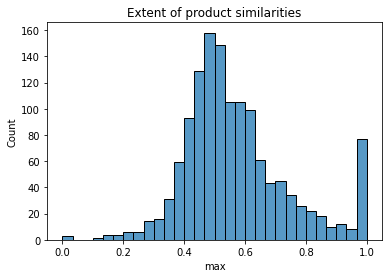

In [430]:
sns.histplot(summary['max'])
plt.title('Extent of product similarities')
plt.show()

In [433]:
print(r'On average, we can find a competitor product that is {}% similar'.format(round(summary['max'].mean()*100,2)))

On average, we can find a competitor product that is 56.93% similar


**Similar products per category**

In [488]:
def list_sim_prod(category, num_pairs):
    s= list(matrix[matrix['prod_type']==category].index)
    s_df = matrix.loc[s,s]
    return s_df.describe().T['max'].sort_values(ascending=False)[:num_pairs*2]

In [489]:
list_sim_prod('toners',4)

REN Clean Skincare Mini Ready Steady Glow Daily AHA Toner    1.000000
REN Clean Skincare Ready Steady Glow Daily AHA Toner         1.000000
CLINIQUE Clarifying Lotion 3                                 0.858395
CLINIQUE Clarifying Lotion 4                                 0.858395
CLINIQUE Clarifying Lotion 1                                 0.801784
innisfree Green Tea Moisture-Balancing Toner                 0.593366
innisfree Ginger Honey Nourishing Ampoule Toner              0.593366
CLINIQUE Clarifying Lotion 2                                 0.592349
Name: max, dtype: float64

In [492]:
list_sim_prod('face wash and cleansers',10)

lilah b. Aglow™ Cleansing Butter Mini                                    1.000000
Dr. Barbara Sturm Enzyme Cleanser                                        1.000000
ONE/SIZE by Patrick Starrr Mini GO OFF Makeup Dissolving Mist            1.000000
Dr. Barbara Sturm Darker Skin Tones Enzyme Cleanser                      1.000000
ONE/SIZE by Patrick Starrr GO OFF Makeup Dissolving Mist                 1.000000
lilah b. Aglow™ Cleansing Butter                                         1.000000
Dior Hydra Life Micellar Milk No Rinse Cleanser                          1.000000
CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips         1.000000
Dior Hydra Life Micellar Water No Rinse Cleanser                         1.000000
CLINIQUE Take The Day Off Makeup Remover For Lids, Lashes & Lips Mini    1.000000
Bobbi Brown Instant Long-Wear Makeup Remover                             1.000000
MILK MAKEUP Mini Vegan Milk Cleanser                                     1.000000
MILK MAKEUP Vega

**Most common ingredients used**

In addition, this would also provide insight into the ingredients discounted in the similarity calculation.

In [450]:
ingr_mapping= cv.vocabulary_
ingr_dict = {v: k for k, v in ingr_mapping.items()}
ingr_count = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
ingr_count.columns= ingr_count.columns.map(ingr_dict)

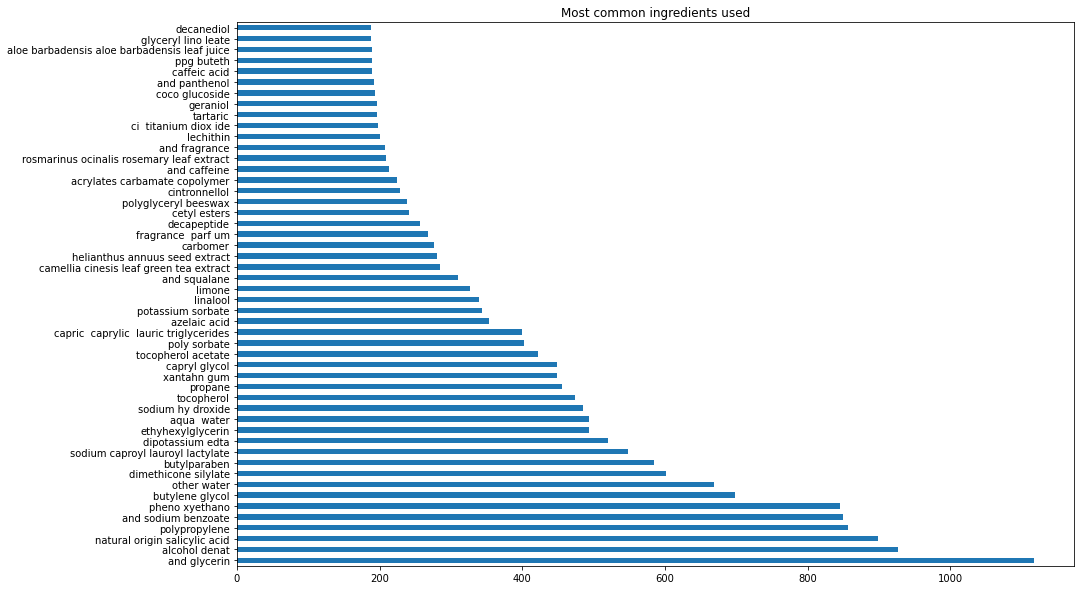

In [428]:
plt.figure(figsize=(15,10))
(ingr_count.sum().sort_values(ascending=False)[:50]).plot.barh()
plt.title('Most common ingredients used')
plt.show()

In [429]:
#Append product name to ingr_count for reference
ingr_count_df = df_new[['product_name']].join(ingr_count)

## 5.0 Saving dataframe

In [83]:
#Saving a copy of ingredients similarity with product name for reference
datapath_df = os.path.join('../data/processed_data', 'product_similarity.json')
if not os.path.exists(datapath_df):
    product_sim_matrix.to_json(datapath_df)

In [108]:
datapath_df = os.path.join('../data/processed_data', 'ingr_count.json')
if not os.path.exists(datapath_df):
    ingr_count_df.to_json(datapath_df)

In [493]:
datapath_df = os.path.join('../data/processed_data', 'cos_sim.json')
if not os.path.exists(datapath_df):
    sim_df.to_json(datapath_df)

In [495]:
datapath_df = os.path.join('../data/processed_data', 'common_ingr.json')
if not os.path.exists(datapath_df):
    dot_prod.to_json(datapath_df)

In [497]:
datapath_df = os.path.join('../data/processed_data', 'product_ingr_inventory.json')
if not os.path.exists(datapath_df):
    prod_ingr_matrix1.to_json(datapath_df)

________________________________________